### Import everything

In [8]:
import os, shutil
import math

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import LearningRateScheduler
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications import InceptionResNetV2
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

import random
import gc   #Gabage collector for cleaning deleted data from memory


In [9]:
folder_paper = './myPictures/paper/'
folder_rock = './myPictures/rock/'
folder_scissors = './myPictures/scissors/'

train_list = {}
train_list["paper"] = [folder_paper+str(i) for i in os.listdir(folder_paper)]
train_list["rock"] = [folder_rock+str(i) for i in os.listdir(folder_rock)]
train_list["scissors"] = [folder_scissors+str(i) for i in os.listdir(folder_scissors)]

shutil.rmtree('./data/')


class_name = ["paper", "rock", "scissors"]
for i in range(3):
    random.shuffle(train_list[class_name[i]])
    if not os.path.exists('./data/train/' + str(class_name[i])):
        os.makedirs('./data/train/' + str(class_name[i]))
    if not os.path.exists('./data/test/' + str(class_name[i])):
        os.makedirs('./data/test/' + str(class_name[i]))
        
    for file in train_list[class_name[i]][:int(0.8* len(train_list[class_name[i]]))]:
        try:
            shutil.copyfile(file, './data/train/' +str(class_name[i]) + "/" +str(file.split('/')[-1]))
        except:
            print(file)
    for file in train_list[class_name[i]][int(0.8* len(train_list[class_name[i]])):]:
        try:
            shutil.copyfile(file, './data/test/' +str(class_name[i]) + "/" +str(file.split('/')[-1]))
        except:
            print(file)

del train_list
gc.collect()

8

In [10]:
vgg_model = VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(150, 150, 3))

# Creating dictionary that maps layer names to the layers
#layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
#x = layer_dict['block2_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(vgg_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='sigmoid')(x)

model = Model(input=vgg_model.input, output=x)

print(len(model.layers))
# Make sure that the pre-trained bottom layers are not trainable
for layer in model.layers[:15]:
    layer.trainable = False
    

# Do not forget to compile it
model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])


25


/home/preiff/.virtualenvs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [3]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))


#opt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [12]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'myPictures_new/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical') 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'myPictures_new/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 642 images belonging to 3 classes.
Found 162 images belonging to 3 classes.


In [13]:
chk = ModelCheckpoint("./callbacks/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


In [14]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        callbacks=[chk],
        validation_data=validation_generator,
        validation_steps=800 // batch_size)


Epoch 1/50
31/31 [==============================] - 17s 559ms/step - loss: 1.1482 - acc: 0.3616 - val_loss: 1.0890 - val_acc: 0.4506
Epoch 2/50
31/31 [==============================] - 16s 511ms/step - loss: 1.0370 - acc: 0.4126 - val_loss: 0.8940 - val_acc: 0.5679
Epoch 3/50
31/31 [==============================] - 16s 517ms/step - loss: 0.9028 - acc: 0.5567 - val_loss: 0.6377 - val_acc: 0.7963
Epoch 4/50
31/31 [==============================] - 16s 514ms/step - loss: 0.5293 - acc: 0.7943 - val_loss: 0.3528 - val_acc: 0.8457
Epoch 5/50
31/31 [==============================] - 16s 514ms/step - loss: 0.3216 - acc: 0.8873 - val_loss: 0.1802 - val_acc: 0.9259
Epoch 6/50
31/31 [==============================] - 16s 524ms/step - loss: 0.1661 - acc: 0.9389 - val_loss: 0.1667 - val_acc: 0.9259
Epoch 7/50
31/31 [==============================] - 16s 513ms/step - loss: 0.1460 - acc: 0.9616 - val_loss: 0.1897 - val_acc: 0.9198
Epoch 8/50
31/31 [==============================] - 16s 514ms/step - 

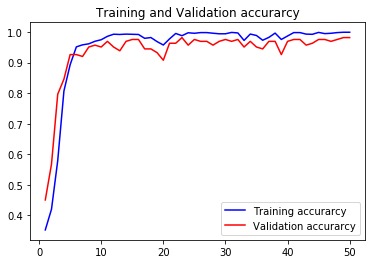

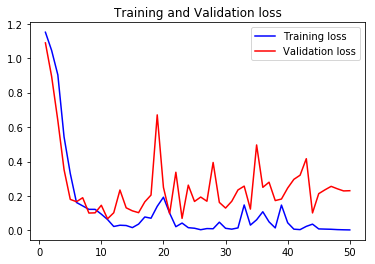

In [15]:

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Found 162 images belonging to 3 classes.


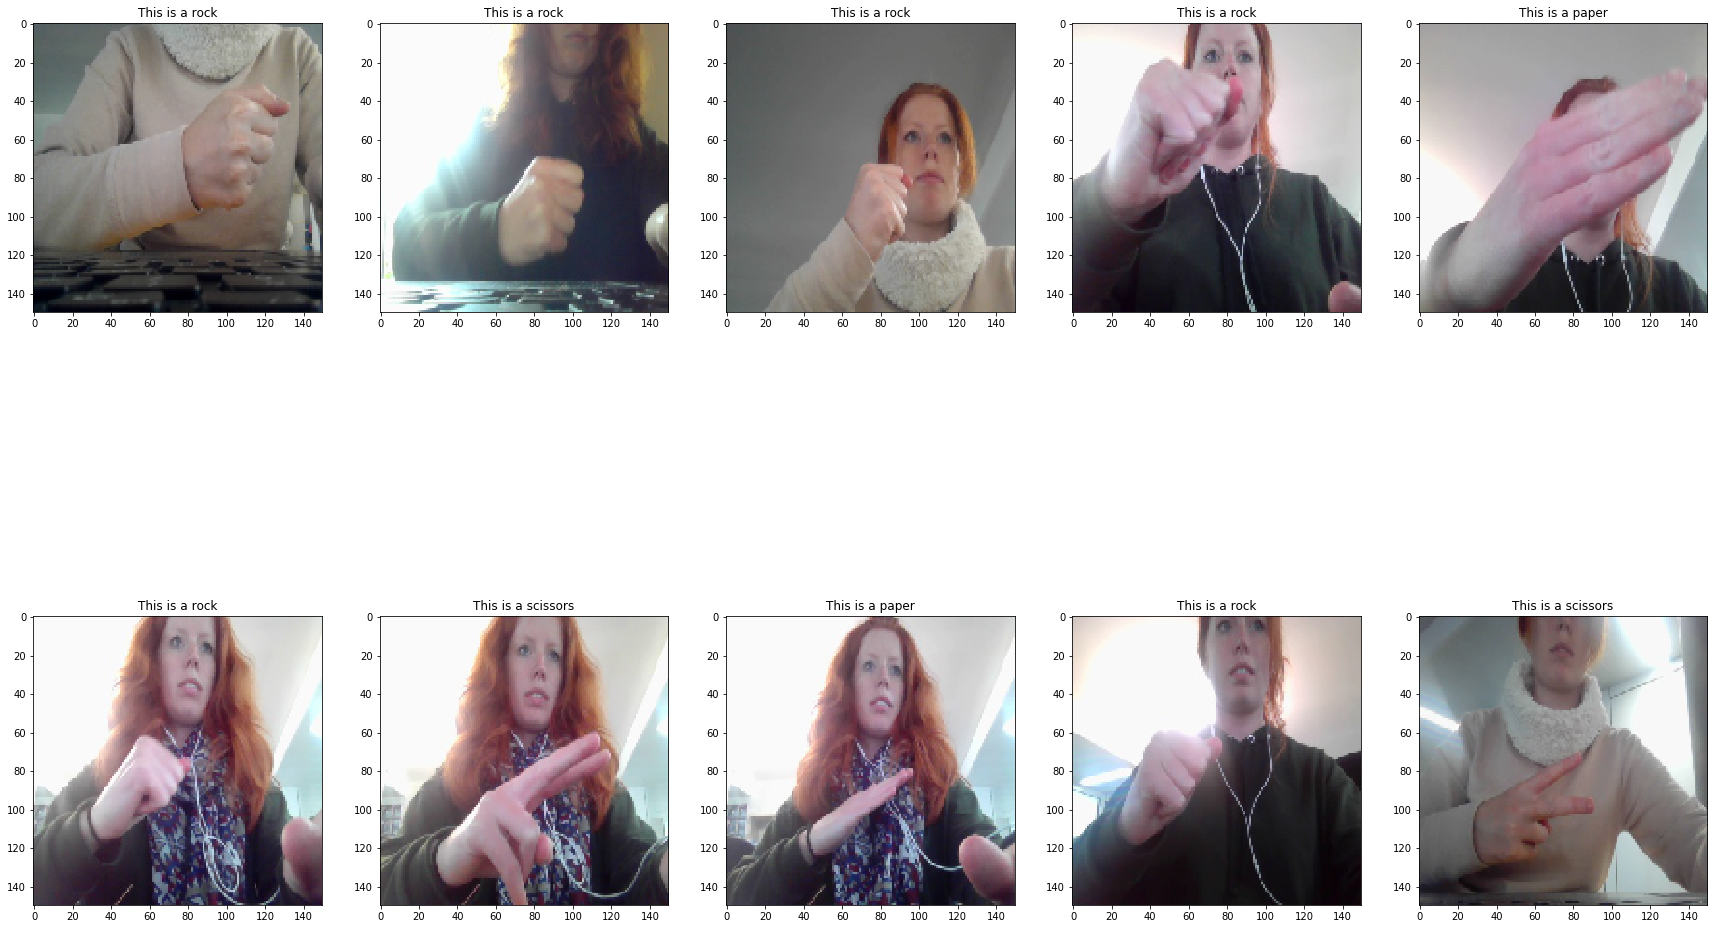

In [16]:
test_generator = test_datagen.flow_from_directory(
        'myPictures_new/test',
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical')

i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_generator:
    img = batch[0]
    pred = model.predict_on_batch(img)
    if np.argmax(pred) == 0:
        text_labels.append("paper")
    elif np.argmax(pred) == 1:
        text_labels.append("rock")
    elif np.argmax(pred) == 2:
        text_labels.append("scissors")
    else:
        text_labels.append("ERROR")
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(img[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

In [8]:
#Save the model
model.save_weights('./classification_weights.h5')
model.save('./classification_model.h5')